# Wholesale Customers

Description:
* 440 rows, 2 parent and 6 child features

Parent features:
* Channel, Region

Child features:
* Fresh, Milk, Grocery, Frozen, Detergents_Paper, Delicassen

Source: https://www.kaggle.com/binovi/wholesale-customers-data-set

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
ws = pd.read_csv("../data/wholesale.csv")

In [3]:
parent = ws[['Channel', 'Region']]
parent.head()

,Channel,Region
0,2,3
1,2,3
2,2,3
3,1,3
4,2,3


In [4]:
child = ws[['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen']]
child.head()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,12669,9656,7561,214,2674,1338
1,7057,9810,9568,1762,3293,1776
2,6353,8808,7684,2405,3516,7844
3,13265,1196,4221,6404,507,1788
4,22615,5410,7198,3915,1777,5185


In [5]:
import sys
sys.path.append("C:/Users/notes/grab")

X = parent.values.astype(np.float32)
y = child.values.astype(np.float32)

In [6]:
import tensorflow as tf
dataset = tf.data.Dataset \
    .from_tensor_slices((X, y)) \
    .shuffle(X.size).batch(40)

In [7]:
from model.gmm import GMM
# Build GMM
gmm = GMM(x_features=X.shape[1],
          y_features=y.shape[1],
          n_components=100,
          n_hidden=50)
gmm.fit(dataset, epochs=1000, plot=True, verbose=True, logdir='gmm_wholesale')

# %loadext tensorboard
# %tensorboard --logdir logs/gmm_wholesale

Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.
0 [NLL: 87736736.0]
100 [NLL: 119868.3984375]
200 [NLL: 7187.14990234375]
300 [NLL: 6961.04296875]
400 [NLL: 4632.9970703125]
500 [NLL: 1881.4281005859375]
600 [NLL: 512.7708129882812]
700 [NLL: 793.0352783203125]
800 [NLL: 826.2509765625]
900 [NLL: 102.30986022949219]


<tf.Tensor: shape=(), dtype=float32, numpy=98.76829>

In [15]:
y_hat = gmm.sample(X)

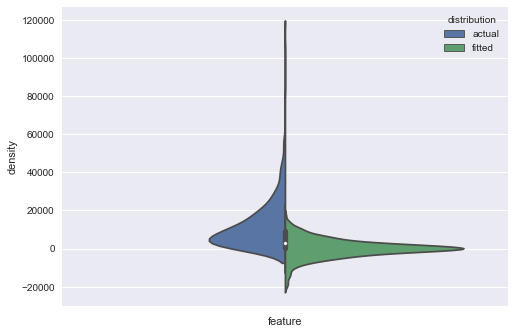

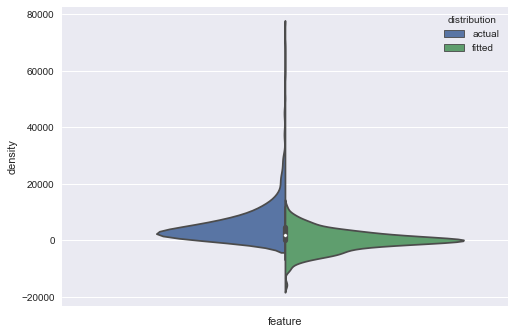

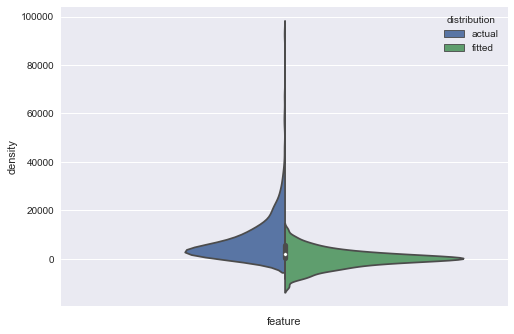

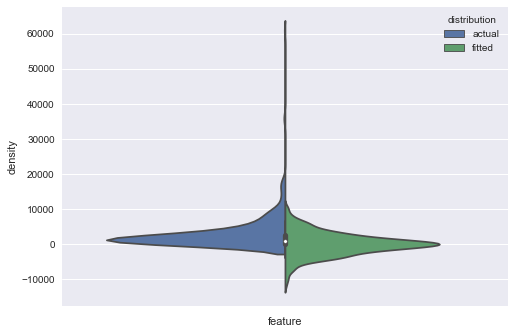

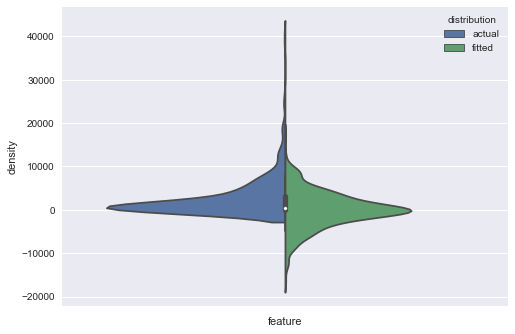

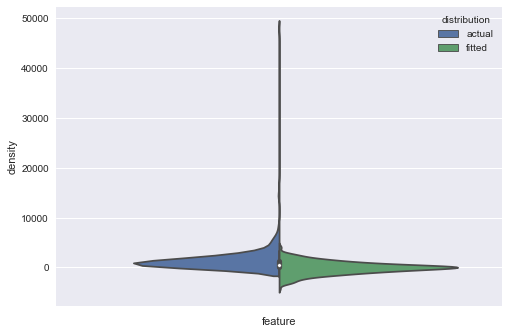

In [16]:
from visualisation.visualisation import Visualisation

gmm_viz = Visualisation(gmm, X, y)
for i in range(y.shape[1]):
    gmm_viz.plot_violin(y[:,i], y_hat[:,i])

In [17]:
from performance.performance import prob_overlap, kl, js

p, q = prob_overlap(y, y_hat, bins=20)
print("fKL:", kl(p, q))
print("rKL:", kl(q, p))
print("JS:", js(p, q))

fKL: 0.501283602022656
rKL: -0.020359148734912937
JS: 0.04223883939256486


In [12]:
from model.cgan import CGAN

cgan = CGAN(x_features=X.shape[1],
            y_features=y.shape[1],
            latent_dim=32,
            g_hidden=32,
            d_hidden=32,
            label_smooth=0.9,
            d_dropout=0.1,
            gp_weight=1)

cgan.fit(dataset, epochs=1000, verbose=True, logdir="cgan_wholesale")

# %loadext tensorboard
# %tensorboard --logdir logs/cgan_wholesale

0 [D loss: -3721.608642578125] [G loss: 0.2744944393634796]
100 [D loss: -197647.015625] [G loss: -5768.4189453125]
200 [D loss: -614251.375] [G loss: -139221.421875]
300 [D loss: -1504955.5] [G loss: -864884.5]
400 [D loss: -548025.75] [G loss: -2339543.25]
500 [D loss: 590390.5] [G loss: -2751683.5]
600 [D loss: -50927.375] [G loss: -1919538.875]
700 [D loss: 53426.75] [G loss: -984299.0]
800 [D loss: -69033.90625] [G loss: -325974.15625]
900 [D loss: -475723.375] [G loss: 411021.40625]


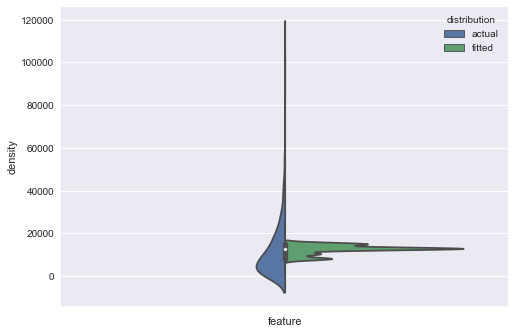

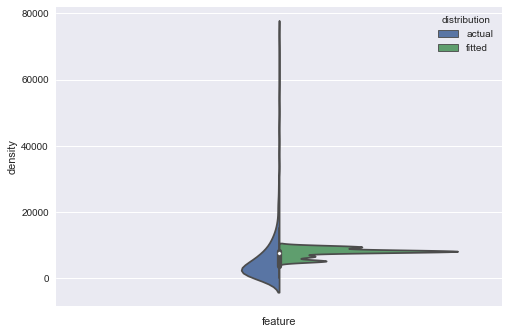

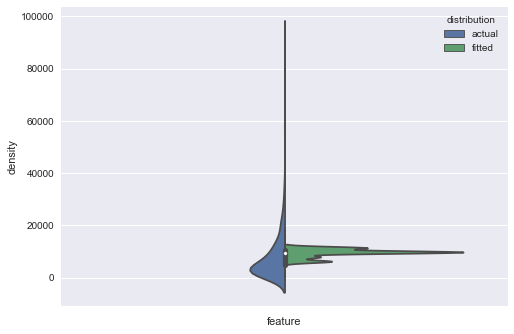

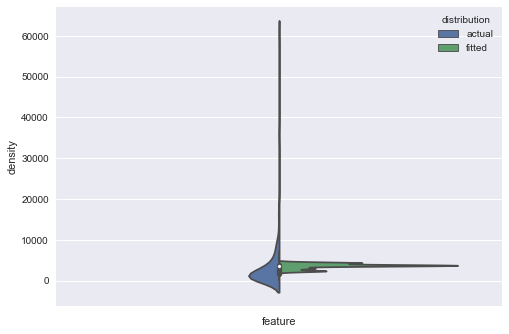

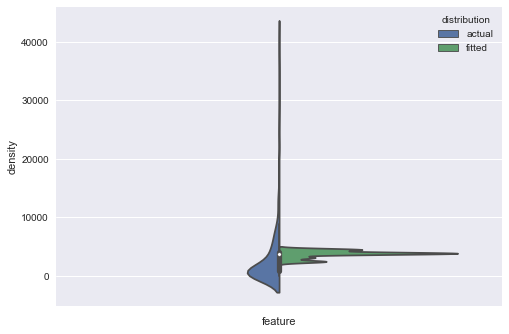

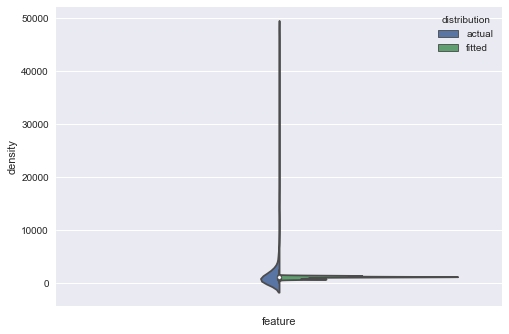

In [13]:
from visualisation.visualisation import Visualisation

y_hat = cgan.sample(X)
cgan_viz = Visualisation(cgan, X, y)
for i in range(y.shape[1]):
    cgan_viz.plot_violin(y[:,i], y_hat[:,i])

In [14]:
from performance.performance import prob_overlap, kl, js

p, q = prob_overlap(y, y_hat, bins=20)
print("fKL:", kl(p, q))
print("rKL:", kl(q, p))  # used in variational bayes
print("JS:", js(p, q))

fKL: -0.029268460100668865
rKL: 0.7780293096164359
JS: 0.06579449277820887
